In [2]:
import numpy as np
import json, torch
from torch.utils.data import DataLoader
from go_metric.data_utils import *
from go_metric.models.bottleneck_dpg_conv import DPGModule
train_path = "/home/andrew/go_metric/data/go_bench"


In [2]:
train_dataset = BertSeqDataset.from_pickle(f"{train_path}/train.pkl")
val_dataset = BertSeqDataset.from_pickle(f"{train_path}/val.pkl")
collate_seqs = get_bert_seq_collator(max_length=1024, add_special_tokens=False)
val_dataloader_params = {"shuffle": False, "batch_size": 256, "collate_fn":collate_seqs}
train_loader = DataLoader(train_dataset, **val_dataloader_params, num_workers=6)
val_loader = DataLoader(val_dataset, **val_dataloader_params, num_workers=6)

In [3]:
from goatools.obo_parser import GODag
ontology = GODag("/home/andrew/go_metric/data/go.obo")
annot_dict = load_GO_tsv_file(f"{train_path}/training_molecular_function_annotations.tsv")
annot_dict.update(load_GO_tsv_file(f"{train_path}/validation_molecular_function_annotations.tsv"))
from go_bench.metrics import calculate_ic, ic_mat
ic_dict = calculate_ic(annot_dict, ontology)
with open(f"{train_path}/molecular_function_terms.json") as f:
    terms = json.load(f)
term_ic = ic_mat(terms, ic_dict)
val_labels = val_dataset.labels.toarray()


/home/andrew/go_metric/data/go.obo: fmt(1.2) rel(2022-07-01) 47,008 Terms


In [10]:
similarity_scores = val_labels @ val_labels[::500, :].T
weighted_sim_scores = (val_labels*term_ic)@val_labels[::500].T

import matplotlib.pyplot as plt
plt.hist(similarity_scores.flatten(), bins=np.linspace(0, 35, 50))
plt.show()
plt.hist(weighted_sim_scores.flatten(), bins=np.linspace(0, 35, 50))
plt.show()

In [64]:
def dot_sim(lA, lB, term_ic):
    return (lA*term_ic)@lB.T

In [62]:
def jaccard_mat(lA, lB, term_ic):
    i = (lA*term_ic) @ lB.T
    max_dot = term_ic.sum()
    nlA = 1-lA
    nlB = 1-lB
    u = (max_dot - (nlA*term_ic)@nlB.T) + 1
    j = i.divide(u)
    return j

# jaccard_sim = jaccard_mat(torch.FloatTensor(val_labels[::100, :]))
l = torch.FloatTensor(val_labels)
tic = torch.FloatTensor(term_ic)

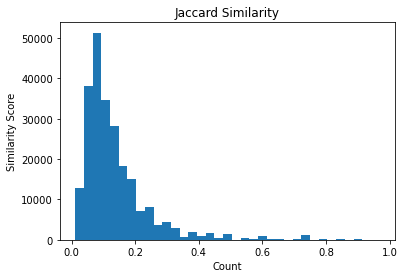

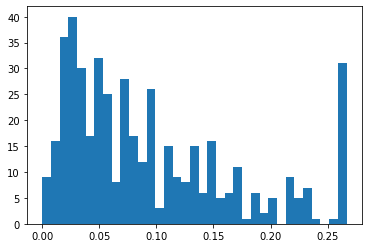

In [73]:
j = jaccard_mat(l[::33], l[::37], torch.ones(tic.shape).reshape((1, -1)))
plt.hist(j.flatten(), bins=35)
plt.xlabel("Count")
plt.ylabel("Similarity Score")
plt.title("Jaccard Similarity")
plt.show()

num_sim = (j > 0.25).sum(dim=0) / j.shape[0]
plt.hist(num_sim, bins=35)
plt.show()

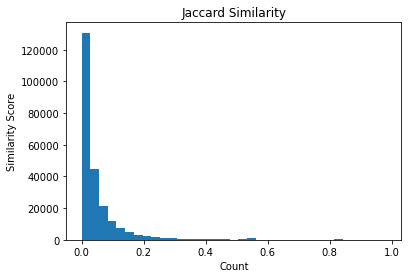

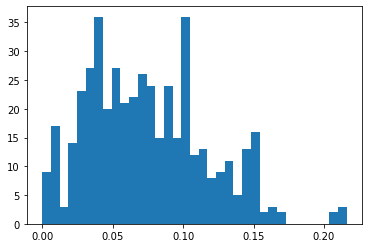

In [70]:
j = jaccard_mat(l[::33], l[::37], tic)
plt.hist(j.flatten(), bins=35)
plt.xlabel("Count")
plt.ylabel("Similarity Score")
plt.title("Jaccard Similarity")
plt.show()

num_sim = (j > 0.15).sum(dim=0) / j.shape[0]
plt.hist(num_sim, bins=35)
plt.show()

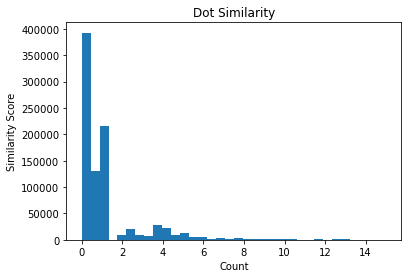

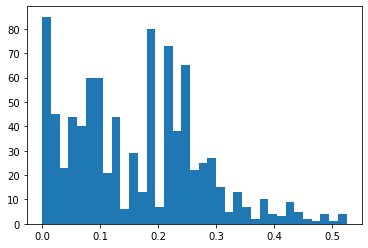

In [69]:
j = dot_sim(l[::17], l[::19], tic)
plt.hist(j.flatten(), bins=np.linspace(0, 15, 35))
plt.xlabel("Count")
plt.ylabel("Similarity Score")
plt.title("Dot Similarity")
plt.show()

num_sim = (j > 2).sum(dim=0) / j.shape[0]
plt.hist(num_sim, bins=35)
plt.show()

In [ ]:

def sigmoid(tensor, temp=1.0):
    exponent = -tensor / temp
    exponent = torch.clamp(exponent, min=-50, max=50)
    y = 1.0 / (1.0 + torch.exp(exponent))
    return y

class RecallatK(torch.nn.Module):
    def __init__(self, anneal, batch_size, num_id, feat_dims, k_vals, k_temperatures, mixup):
        super(RecallatK, self).__init__()
        assert(batch_size%num_id==0)
        self.anneal = anneal
        self.batch_size = batch_size
        self.num_id = num_id
        self.feat_dims = feat_dims
        self.k_vals = [min(batch_size, k) for k in k_vals]
        self.k_temperatures = k_temperatures
        self.mixup = mixup
        self.samples_per_class = int(batch_size/num_id)

    def forward(self, preds, q_id):
        batch_size = preds.shape[0]
        num_id = self.num_id
        anneal = self.anneal
        feat_dims = self.feat_dims
        k_vals = self.k_vals
        k_temperatures = self.k_temperatures
        samples_per_class = int(batch_size/num_id)
        norm_vals = torch.Tensor([min(k, (samples_per_class-1)) for k in k_vals]).cuda()
        group_num = int(q_id/samples_per_class)
        q_id_ = group_num*samples_per_class

        sim_all = (preds[q_id]*preds).sum(1)
        sim_all_g = sim_all.view(num_id, int(batch_size/num_id))
        sim_diff_all = sim_all.unsqueeze(-1) - sim_all_g[group_num, :].unsqueeze(0).repeat(batch_size,1)
        sim_sg = sigmoid(sim_diff_all, temp=anneal)
        for i in range(samples_per_class): sim_sg[group_num*samples_per_class+i,i] = 0.
        sim_all_rk = (1.0 + torch.sum(sim_sg, dim=0)).unsqueeze(dim=0)

        sim_all_rk[:, q_id%samples_per_class] = 0.
        sim_all_rk = sim_all_rk.unsqueeze(dim=-1).repeat(1,1,len(k_vals))
        k_vals = torch.Tensor(k_vals).cuda()
        k_vals = k_vals.unsqueeze(dim=0).unsqueeze(dim=0).repeat(1, samples_per_class, 1)
        sim_all_rk = k_vals - sim_all_rk
        for given_k in range(0, len(self.k_vals)):
            sim_all_rk[:,:,given_k] = sigmoid(sim_all_rk[:,:,given_k], temp=float(k_temperatures[given_k]))

        sim_all_rk[:,q_id%samples_per_class,:] = 0.
        k_vals_loss = torch.Tensor(self.k_vals).cuda()
        k_vals_loss = k_vals_loss.unsqueeze(dim=0)
        recall = torch.sum(sim_all_rk, dim=1)
        recall = torch.minimum(recall, k_vals_loss)
        recall = torch.sum(recall, dim=0)
        recall = torch.div(recall, norm_vals)
        recall = torch.sum(recall)/len(self.k_vals)
        return (1.-recall)/batch_size